CARS

This code performs feature selection using the CARS algorithm with PLS regression, evaluates model performance via cross-validated RMSE, and prints the best subset of features and their predictive accuracy.


In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


def cv_rmse(X, y, n_components, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmses = []
    for train_idx, test_idx in kf.split(X):
        model = PLSRegression(n_components=n_components)
        model.fit(X[train_idx], y[train_idx])
        y_pred = model.predict(X[test_idx])
        rmses.append(np.sqrt(mean_squared_error(y[test_idx], y_pred)))
    return np.mean(rmses)


def compute_vip(pls, X, Y):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_

    p, h = w.shape
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    Wnorm2 = np.sum(w ** 2, axis=0)
    vip = np.zeros((p,))
    for i in range(p):
        weight = np.sum([s[j] * (w[i, j] ** 2) / Wnorm2[j] for j in range(h)])
        vip[i] = np.sqrt(p * weight / np.sum(s))
    return vip

def cars_pls(X, Y, n_components=8, n_iter=50, min_vars_ratio=0.02,
             sampling="weighted", random_state=None):
    rng = np.random.default_rng(random_state)

    n_samples, n_features = X.shape
    min_vars = max(2, int(n_features * min_vars_ratio))
    current_idx = np.arange(n_features)

    selected_sets = []
    rmse_path = []
    num_vars_path = []

    for it in range(n_iter):
        X_sel = X[:, current_idx]

        pls = PLSRegression(n_components=n_components)
        pls.fit(X_sel, Y)
        vip_scores = compute_vip(pls, X_sel, Y)

       
        rmse = cv_rmse(X_sel, Y, n_components=n_components)
        rmse_path.append(rmse)
        num_vars_path.append(len(current_idx))
        selected_sets.append(current_idx.copy())

        
        if len(current_idx) <= min_vars:
            break

       
        decay_factor = (min_vars / n_features) ** (1 / n_iter)
        next_size = max(min_vars, int(len(current_idx) * decay_factor))

        
        if sampling == "weighted":
           
            probs = vip_scores / np.sum(vip_scores)
            if next_size < len(current_idx):
                new_local_idx = rng.choice(
                    len(current_idx), size=next_size,
                    replace=False, p=probs
                )
            else:
                new_local_idx = np.arange(len(current_idx))
        else:
            new_local_idx = np.arange(np.argsort(-vip_scores)[:next_size])

        current_idx = current_idx[new_local_idx]

   
    chosen_iter = int(np.argmin(rmse_path))
    best_features = selected_sets[chosen_iter]

    return best_features, rmse_path, num_vars_path, selected_sets, chosen_iter


if __name__ == "__main__":
    
    X = np.loadtxt("dataF_final.csv", delimiter=",")  # shape: (258, 1868)
    Y = np.loadtxt("dataC_final.csv", delimiter=",")

     
    scalerX = StandardScaler()
    scalerY = StandardScaler()
    X = scalerX.fit_transform(X)
    Y = scalerY.fit_transform(Y)

     
    cars_features, rmse_path, num_vars_path, all_sets, chosen_iter = cars_pls(
        X, Y,
        n_components=8,
        n_iter=50,
        min_vars_ratio=0.02,
        sampling="weighted",
        random_state=42
    )

    print("\n=== CARS Result ===")
    print("Chosen iteration (0-based):", chosen_iter)
    print("Best subset size:", len(cars_features))
    print("Best RMSE:", rmse_path[chosen_iter])
    print("Selected feature indices:", cars_features)

     
    rmse_selected = cv_rmse(X[:, cars_features], Y, n_components=8)
    rmse_all = cv_rmse(X, Y, n_components=8)

    print("\n=== Final Evaluation ===")
    print(f"PLS RMSE (all features): {rmse_all:.4f}")
    print(f"PLS RMSE (CARS-selected features): {rmse_selected:.4f}")

     
    print("\n-- PLS --")
    pls_final = PLSRegression(n_components=8)
    pls_final.fit(X[:, cars_features], Y)
    Y_pred = pls_final.predict(X[:, cars_features])

    n_targets = Y.shape[1]
    for i in range(n_targets):
        y_true = Y[:, i]
        y_pred = Y_pred[:, i]
        r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rep = (rmse / np.mean(np.abs(y_true))) * 100
        print(f"Target {i+1}: R²={r2:.4f} | RMSE={rmse:.4f} | REP%={rep:.2f}")



=== CARS Result ===
Chosen iteration (0-based): 14
Best subset size: 618
Best RMSE: 0.8514875412493881
Selected feature indices: [ 202 1307 1092 1078  155 1244 1541  361  294  435  397 1734 1656 1200
  664  833  182 1445 1382  498  487 1089   57  544  382  446  593  959
  886 1360 1706  354  897 1246 1214  187 1000 1348  136 1277 1539 1693
 1837 1013  900 1744  685 1459  772  440 1799  191 1534   77  502  945
  547 1070 1334  469  598 1690  416 1861  878 1338 1809 1069 1523 1801
 1462  129  708  914 1839 1795  866 1328 1227 1237 1105 1691 1762 1757
   44 1386 1394  710 1051  200  817 1223 1201    6  775 1773 1495 1036
 1856  958  278  181  920  318  410  337 1798   73 1339  627 1479  782
 1735  447 1357   14 1274  212 1807 1027 1112 1405  946 1340 1080 1157
 1408 1494  908 1303 1283 1675 1637  381 1047  811  560  689 1518 1830
   71  994 1093 1685 1317 1032 1612  912   21 1640 1849  114  645   58
 1243 1298 1321  850  676  391 1005 1670  341  795 1083  595  824  150
 1684  977  856  4

This code evaluates Ridge, Lasso, and ElasticNet models on all vs. CARS-selected features for multiple targets and visualizes their R², RMSE, and REP% scores.



=== Evaluating on All Features ===

-- Ridge --
Target 1: R²=0.9999 | RMSE=20.5265 | REP%=0.91
Target 2: R²=0.9991 | RMSE=90.1297 | REP%=4.16
Target 3: R²=1.0000 | RMSE=4.2283 | REP%=0.66
Target 4: R²=0.9991 | RMSE=75.3148 | REP%=3.82
Target 5: R²=0.9991 | RMSE=0.0544 | REP%=7.77


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.693e+05, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.787e+04, tolerance: 4.605e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in


-- Lasso --
Target 1: R²=0.9999 | RMSE=19.5672 | REP%=0.86
Target 2: R²=0.9991 | RMSE=89.6798 | REP%=4.14
Target 3: R²=1.0000 | RMSE=1.7589 | REP%=0.28
Target 4: R²=0.9991 | RMSE=74.8329 | REP%=3.79
Target 5: R²=0.9790 | RMSE=0.2619 | REP%=37.40


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.278e+06, tolerance: 9.129e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.792e+06, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in


-- ElasticNet --
Target 1: R²=0.9999 | RMSE=21.2085 | REP%=0.94
Target 2: R²=0.9991 | RMSE=90.4569 | REP%=4.18
Target 3: R²=1.0000 | RMSE=5.4859 | REP%=0.86
Target 4: R²=0.9991 | RMSE=75.6712 | REP%=3.84
Target 5: R²=0.9921 | RMSE=0.1606 | REP%=22.94

=== Evaluating on CARS-Selected Features ===

-- Ridge --
Target 1: R²=0.9995 | RMSE=40.5717 | REP%=1.79
Target 2: R²=0.9987 | RMSE=109.1190 | REP%=5.04
Target 3: R²=0.9997 | RMSE=24.5992 | REP%=3.86
Target 4: R²=0.9986 | RMSE=93.7458 | REP%=4.75
Target 5: R²=0.9985 | RMSE=0.0710 | REP%=10.14


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.191e+05, tolerance: 9.129e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.393e+05, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in


-- Lasso --
Target 1: R²=0.9999 | RMSE=19.5756 | REP%=0.86
Target 2: R²=0.9991 | RMSE=89.6823 | REP%=4.14
Target 3: R²=1.0000 | RMSE=1.8480 | REP%=0.29
Target 4: R²=0.9991 | RMSE=74.8355 | REP%=3.79
Target 5: R²=0.9377 | RMSE=0.4510 | REP%=64.40


C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.221e+06, tolerance: 9.129e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.419e+07, tolerance: 2.278e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\96170\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in


-- ElasticNet --
Target 1: R²=0.9993 | RMSE=49.2596 | REP%=2.18
Target 2: R²=0.9984 | RMSE=118.6135 | REP%=5.48
Target 3: R²=0.9995 | RMSE=31.0644 | REP%=4.88
Target 4: R²=0.9983 | RMSE=102.8917 | REP%=5.21
Target 5: R²=0.9709 | RMSE=0.3079 | REP%=43.97


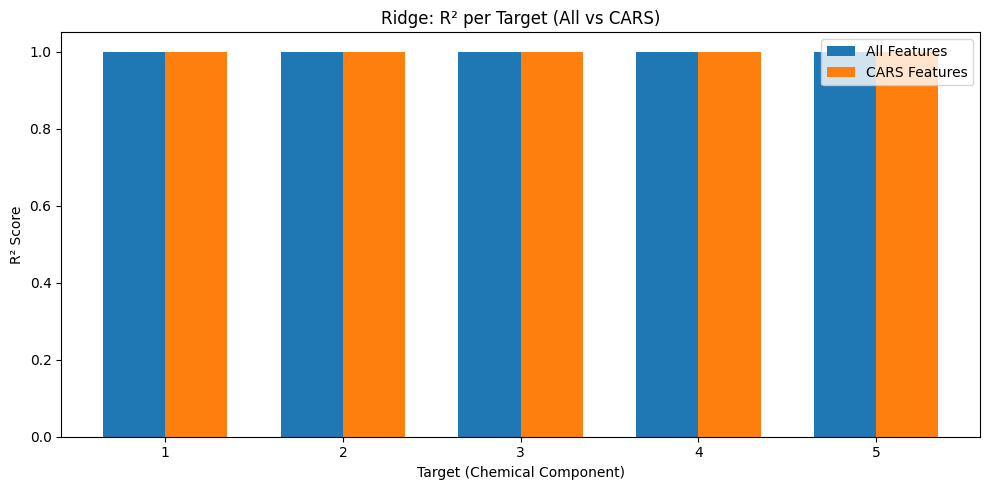

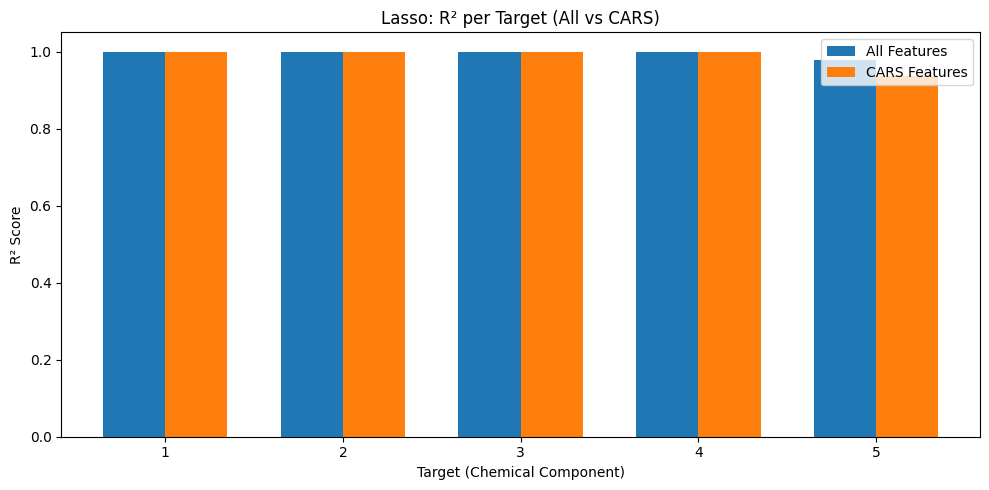

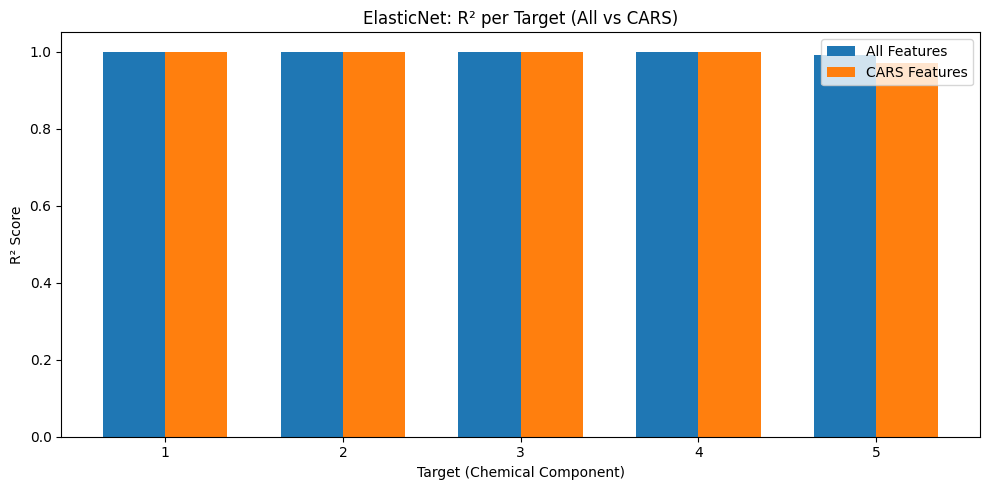

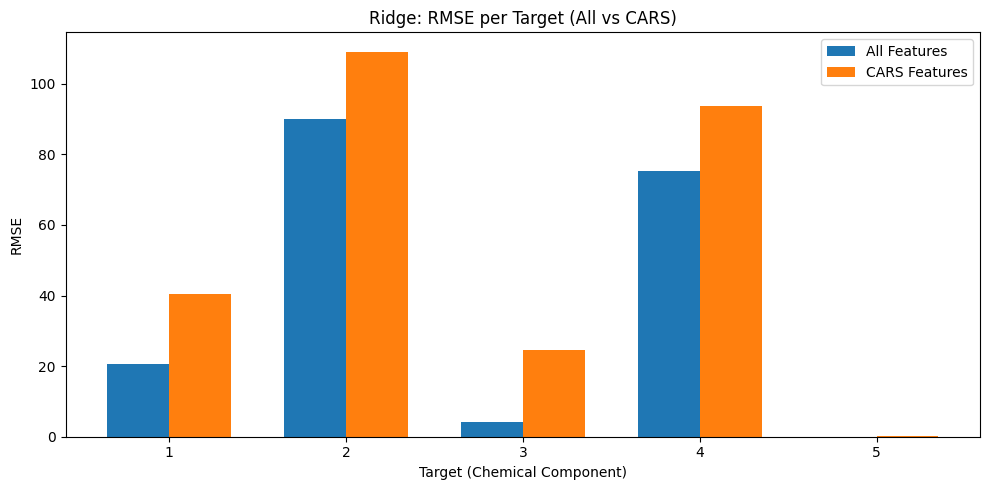

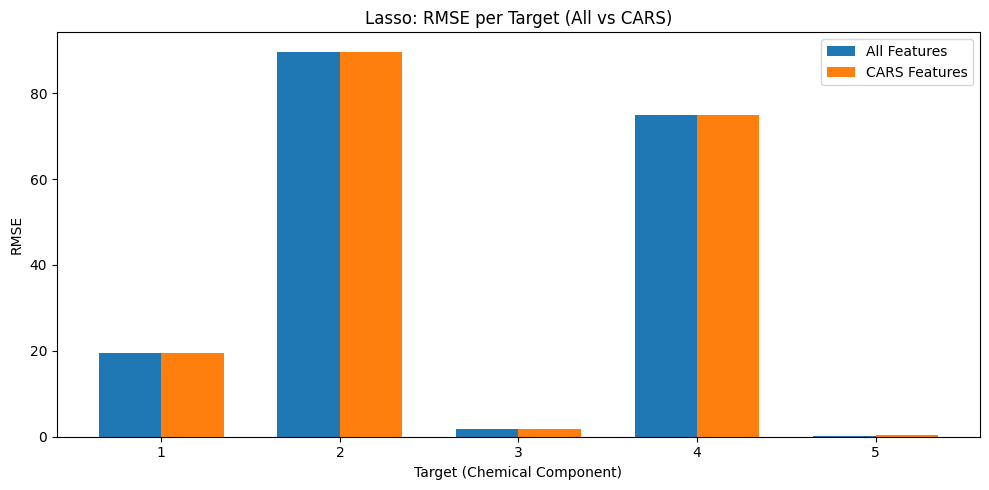

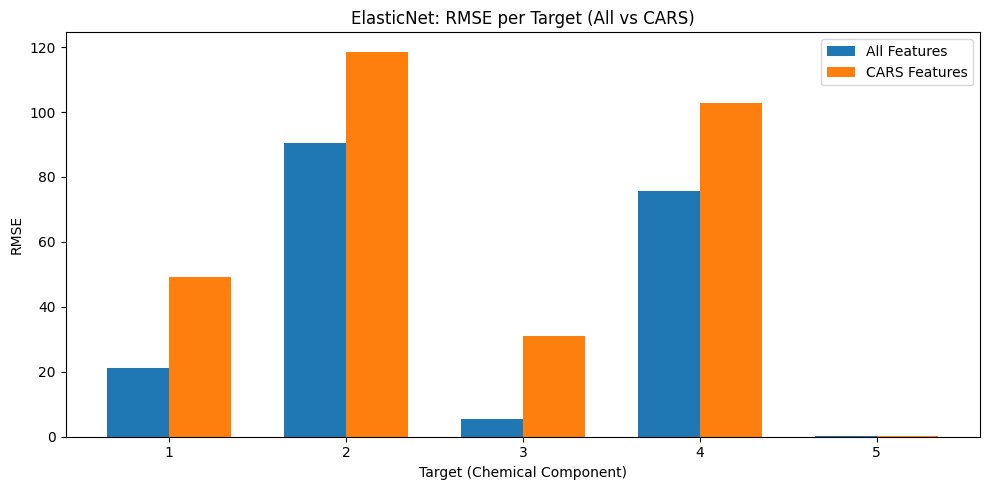

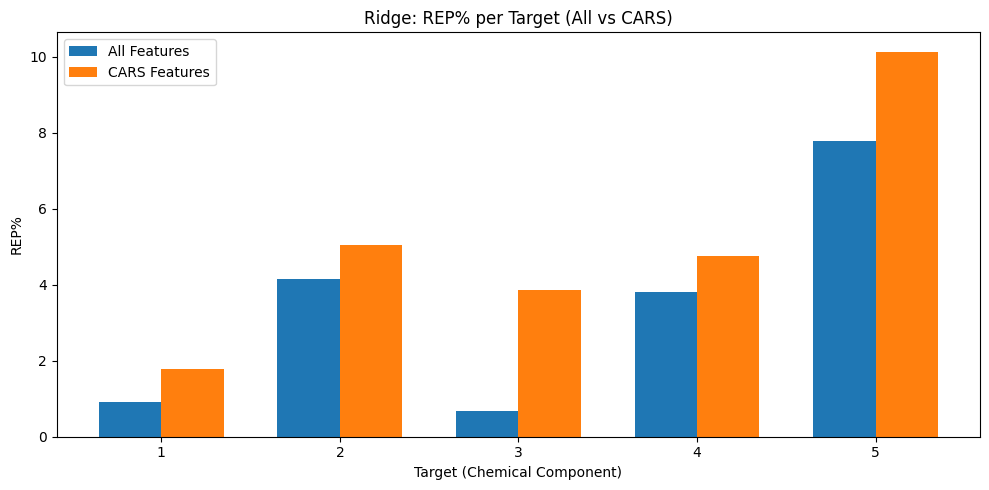

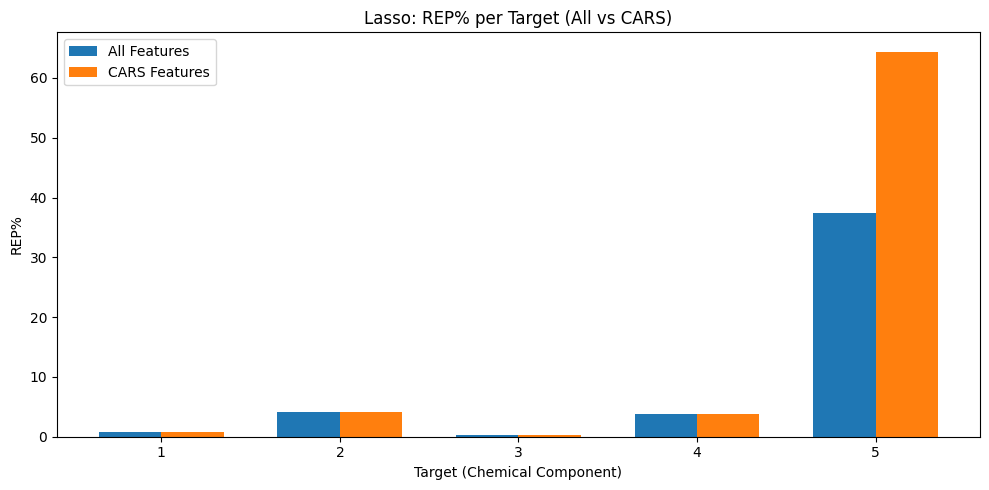

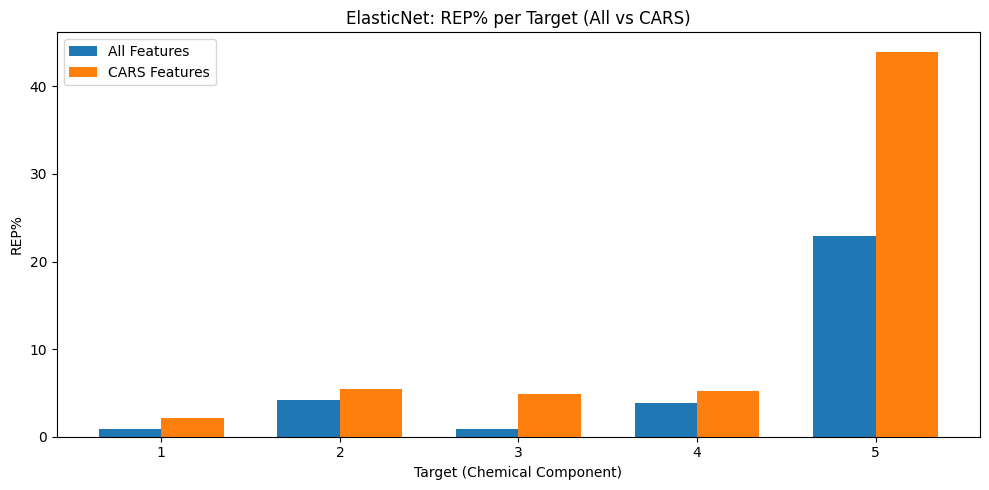

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

 
X = np.loadtxt("dataF_final.csv", delimiter=",")   
Y = np.loadtxt("dataC_final.csv", delimiter=",")   
 
X_cars = X[:, cars_features]

if Y.ndim == 1:
    Y = Y.reshape(-1, 1)
n_targets = Y.shape[1]

 
def evaluate_model(model, X_input, Y_true):
    """
    Fit model on X_input, Y_true (multi-target handled separately)
    Returns: r2_list, rmse_list, rep_list, Y_pred_all
    """
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X_input)
    
    Y_pred_all = np.zeros_like(Y_true)
    r2_list, rmse_list, rep_list = [], [], []

    for t in range(n_targets):
        y_true = Y_true[:, t]
        # Fit separately for each target
        model.fit(X_scaled, y_true)
        y_pred = model.predict(X_scaled)
        Y_pred_all[:, t] = y_pred

        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mean_val = np.mean(y_true)
        rep = (rmse / mean_val) * 100 if mean_val != 0 else np.nan

        r2_list.append(r2)
        rmse_list.append(rmse)
        rep_list.append(rep)

    return r2_list, rmse_list, rep_list, Y_pred_all

 
ridge_model = Ridge(alpha=1.0)
lasso_model = Lasso(alpha=0.01, max_iter=10000)
elastic_model = ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000)

models = {
    "Ridge": ridge_model,
    "Lasso": lasso_model,
    "ElasticNet": elastic_model
}

datasets = {
    "All Features": X,
    "CARS-Selected Features": X_cars
}

 
results = {}

for d_name, X_input in datasets.items():
    print(f"\n=== Evaluating on {d_name} ===")
    results[d_name] = {}
    for m_name, model in models.items():
        r2_list, rmse_list, rep_list, Y_pred = evaluate_model(model, X_input, Y)
        results[d_name][m_name] = {
            "R²": r2_list,
            "RMSE": rmse_list,
            "REP%": rep_list
        }
         
        print(f"\n-- {m_name} --")
        for t in range(n_targets):
            print(f"Target {t+1}: R²={r2_list[t]:.4f} | RMSE={rmse_list[t]:.4f} | REP%={rep_list[t]:.2f}")

 
for m_name in models.keys():
    plt.figure(figsize=(10,5))
    width = 0.35
    x = np.arange(1, n_targets+1)
    plt.bar(x - width/2, results["All Features"][m_name]["R²"], width, label="All Features")
    plt.bar(x + width/2, results["CARS-Selected Features"][m_name]["R²"], width, label="CARS Features")
    plt.xticks(x)
    plt.xlabel("Target (Chemical Component)")
    plt.ylabel("R² Score")
    plt.title(f"{m_name}: R² per Target (All vs CARS)")
    plt.legend()
    plt.tight_layout()
    plt.show()

 
for metric in ["RMSE", "REP%"]:
    for m_name in models.keys():
        plt.figure(figsize=(10,5))
        width = 0.35
        x = np.arange(1, n_targets+1)
        plt.bar(x - width/2, results["All Features"][m_name][metric], width, label="All Features")
        plt.bar(x + width/2, results["CARS-Selected Features"][m_name][metric], width, label="CARS Features")
        plt.xticks(x)
        plt.xlabel("Target (Chemical Component)")
        plt.ylabel(metric)
        plt.title(f"{m_name}: {metric} per Target (All vs CARS)")
        plt.legend()
        plt.tight_layout()
        plt.show()
